# Spike synchrony
1. Cross correlation
2. Unitary event analysis
3. My method

In [59]:
import elephant
import quantities as pq
from neo.core import AnalogSignal
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import random
import viziphant.unitary_event_analysis as vue
from scipy.stats import norm, binom

Simulate 2 neurons, synchronized to the same underlying oscillation (aka, both have a rhythmic and sycnhronized firing rate)

In [73]:
np.random.seed(1224)
fs = 1000
times = np.arange(0, 2, 1/fs)
freq = 20
mean_rate = 60
osc = np.sin(2 * np.pi * times[:] * freq)
osc_rate = mean_rate * osc
osc_rate += mean_rate #make sure rate is always positive
sim_spike_rate = AnalogSignal(np.expand_dims(osc_rate, 1), units='Hz', sampling_rate=1000*pq.Hz)
st1 = elephant.spike_train_generation.inhomogeneous_poisson_process(rate=sim_spike_rate, refractory_period=3*pq.ms)
st2 = elephant.spike_train_generation.inhomogeneous_poisson_process(rate=sim_spike_rate, refractory_period=3*pq.ms)

 ## Cross correlation
 
 See *spiketrain_analyses*, **autocorrelation** section. This is the same analysis, but instead of comparing a spike train with itself, here we're comparing two spike trains.
 


Text(0, 0.5, 'Count')

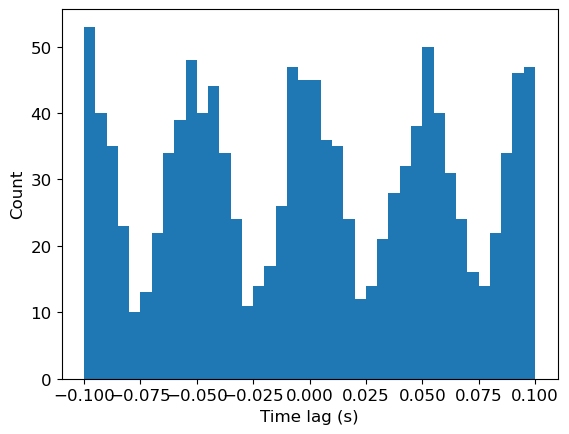

In [54]:
spikes1 = np.squeeze(st1)
spikes2 = np.squeeze(st2)

binsize = .005
max_lag = .1
start_win, stop_win = times[0] + max_lag, times[-1] - max_lag
histo_bins = int((max_lag*2)/binsize)

spike_diffs = []

for i, spike1 in enumerate(spikes1):
    if spike1>start_win and spike1<stop_win:
        for j, spike2 in enumerate(spikes2):
                spike_diff = spike1 - spike2
                if np.abs(spike_diff)<max_lag: 
                    spike_diffs.append(spike1 - spike2)
        
counts, bins, patches = plt.hist(spike_diffs, bins=histo_bins)
plt.xlabel('Time lag (s)')
plt.ylabel('Count')

TODO: Examples where a metric is computed from the cross correlation?

## Unitary event analysis

Unitary event analysis essentially computes the number of synchronous spikes [[1]](#References). Because some number of synchronous spikes are expected by chance, this number is then compared to an 'expected' number of spikes. 

In [86]:
# Compute number of synchronous spikes
binned_st1 = elephant.conversion.BinnedSpikeTrain(st1, bin_size=5*pq.ms) #Binarize spike train
binned_st2 = elephant.conversion.BinnedSpikeTrain(st2, bin_size=5*pq.ms) #Binarize spike train

sync_events = np.logical_and(binned_st1.to_bool_array(),binned_st2.to_bool_array()) #Find where spikes occurred in both spiketrains
n_events = np.sum(sync_events)
n_bins = sync_events.shape[1]
print('Number of bins: '+ str(n_bins))
print('Number of synchronous events: ' + str(n_events))

Number of bins: 400
Number of synchronous events: 43


Now, let's compare this number with how much we would expect by chance. There are a few ways to compute this. Analytically,  we have two spike trains with a mean rate of 60Hz. Therefore, each neuron spikes .3 times per 5ms, and for any 5ms bin, the probability of both neurons spiking is .09. We can calculate the probability that we observe 43 synchronous events or greater using a binomial distribution.

In [88]:
# Analytic
p = binom.sf(n_events, n_bins, .09)
print('Analytic probability: '+ str(p))

Analytic probability: 0.09754615335115961


Though simple and efficient, this method works only when the firing rate of neurons is stationary over time. However, the firing rate of neurons can change over time, in ways that are correlated with one another that may be spurious to this analysis. This can occur with the onset of a stimulus, or a neuromodulator.

To deal with non-stationarities, there are several methods to create surrogate spike trains, which the actual number of synchronous events can be compared with [[2]](#References). Surrogates are commonly created by dithering (or jittering) a spike train by randomly moving each spike by some time within some small time frame. Alternatively, surrogates can be created by randomly shifting spike trains against each other, conserving the original structure of each spike train but requiring ultimately large time shifts. When analyzing synchrony evoked by a stimulus, spike trains can be shifted across trials, such that the number of synchronous events can be compared with the number of synchronous events found when comparing neurons recorded in different trials. However, this analysis assumes stationarity can be assumed across trials, which is generally unlikely.

Here, let's dither to create surrogate spike trains, and compare the actual number of synchronous events with this distribution.

In [101]:
# Compare with surrogate spike trains
np.random.seed(2022)
surr_evts = []
surr_sts = elephant.spike_train_surrogates.dither_spikes(st2, 10*pq.ms, n_surrogates=200)
for surr_st in surr_sts:
    binned_surr_st = elephant.conversion.BinnedSpikeTrain(surr_st, bin_size=5*pq.ms) #Binarize spike train
    sync_events = np.logical_and(binned_st1.to_bool_array(),binned_surr_st.to_bool_array()) #Find where spikes occurred in both spiketrains
    surr_evts.append(np.sum(sync_events))

Dithered probability: 0.10832211715896994


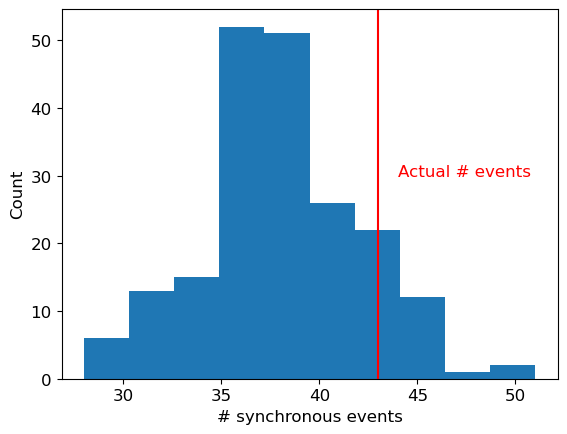

In [108]:
plt.hist(surr_evts)
plt.axvline(n_events, color='red')
plt.xlabel('# synchronous events')
plt.ylabel('Count')
plt.text(n_events+1, 30, 'Actual # events', color='red')

z_score = (n_events - np.mean(surr_evts)) / np.std(surr_evts)

dith_p = norm.sf(z_score)
print('Dithered probability: '+ str(dith_p))

Now, let's simulate two spike trains that only become synchronous after 1s. 

In [70]:
np.random.seed(2022)
fs = 1000
times = np.arange(0, 2, 1/fs)
freq = 20
mean_rate = 60
osc = np.sin(2 * np.pi * times[:] * freq)
osc_rate = np.zeros(len(times))
osc_rate[1000:] = mean_rate * osc[:1000]
osc_rate += mean_rate #make sure rate is always positive
sim_spike_rate = AnalogSignal(np.expand_dims(osc_rate, 1), units='Hz', sampling_rate=1000*pq.Hz)
st1 = elephant.spike_train_generation.inhomogeneous_poisson_process(rate=sim_spike_rate, refractory_period=3*pq.ms)
st2 = elephant.spike_train_generation.inhomogeneous_poisson_process(rate=sim_spike_rate, refractory_period=3*pq.ms)

We can calculate how synchrony changes over time using elephant's jointJ_window_analysis function, and plot it using the plot_ue function from viziphant (elephant's companion visualization package).

In [71]:
spiketrains = [[st1, st2]]
random.seed(2022)
UEs = elephant.unitary_event_analysis.jointJ_window_analysis(spiketrains, bin_size=5*pq.ms, winsize=500*pq.ms, winstep=50*pq.ms, pattern_hash=[3])

FigureUE(axes_spike_events=<AxesSubplot: title={'center': 'Spike Events'}, ylabel='Trial'>, axes_spike_rates=<AxesSubplot: title={'center': 'Spike Rates'}, ylabel='Hz'>, axes_coincident_events=<AxesSubplot: title={'center': 'Coincident Events'}, ylabel='Trial'>, axes_coincidence_rates=<AxesSubplot: title={'center': 'Coincidence Rates'}, ylabel='Hz'>, axes_significance=<AxesSubplot: title={'center': 'Statistical Significance'}>, axes_unitary_events=<AxesSubplot: title={'center': 'Unitary Events'}, xlabel='Time (ms)', ylabel='Trial'>)

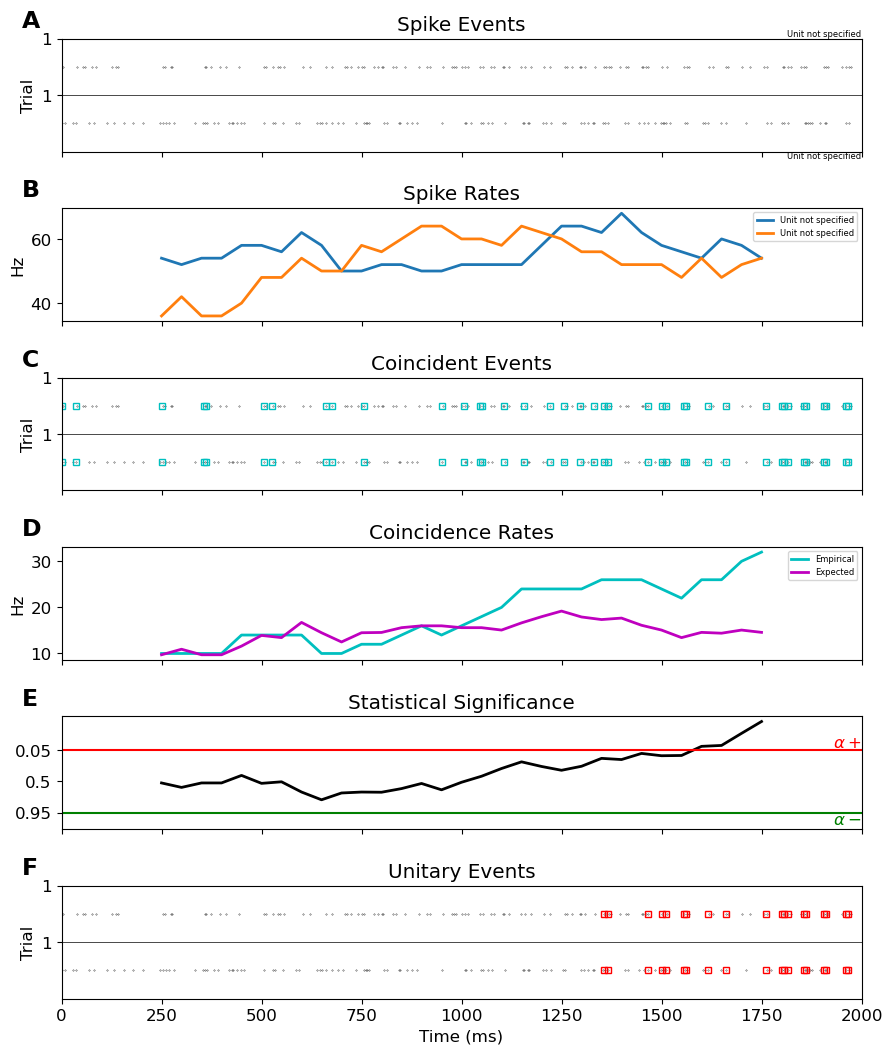

In [72]:
vue.plot_ue(spiketrains, UEs, significance_level=0.05)

Elephant's visualization shows many coincident events. Additionally, the actual coincidence rate is generally higher than the expected, as calculated analytically. However, the windows only reach significance around 1s, and only coincident events in these windows are marked as unitary events.

## Kernel-based metric

# References
1. Grün, S., Diesmann, M., Grammont, F., Riehle, A., & Aertsen, A. (1999). Detecting unitary events without discretization of time. Journal of neuroscience methods, 94(1), 67-79
2. Grün, S. (2009). Data-driven significance estimation for precise spike correlation. Journal of Neurophysiology, 101(3), 1126–1140. https://doi.org/10.1152/JN.00093.2008/ASSET/IMAGES/LARGE/Z9K0030993390009.JPEG